In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import albumentations as A
from albumentations.pytorch import ToTensor
from brainmri.dataset.stacker import MriStacker
from brainmri.dataset.dataset import BrainMriSegmentation, get_dataloader

In [2]:
stacker = MriStacker(root_dir=None, # Not preprocessing stacks no need to point to root directory with MRI images
                         out_dir="/home/nlittlefield/Documents/2.5D-brain-mri-segmentation/data/lgg-mri-segmentation/2.5D/StackSize=3/",
                         stack_size=3)

stacker.gen_train_val_test_split()

In [3]:
test_ds = BrainMriSegmentation(stacker.test_df, transforms=A.Compose([ToTensor()]), preprocessing=None)
test_dl = get_dataloader(test_ds, bs=2)

In [4]:
model = torch.load("/home/nlittlefield/Documents/2.5D-brain-mri-segmentation/models/unet-scratch_aug_2021-08-26.pth")
model.cuda()

DataParallel(
  (module): UNet(
    (conv_down1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (conv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (conv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (conv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

torch.Size([2, 1, 256, 256])
(2, 1, 256, 256)


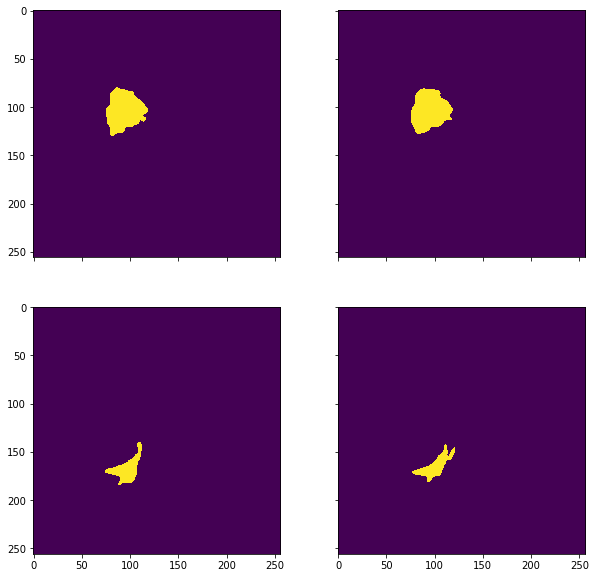

In [5]:
batch = next(iter(test_dl))
preds = model(batch[0].cuda()).detach().cpu()
print(preds.shape)

out_cut = np.copy(preds.detach().cpu().numpy())
print(out_cut.shape)
out_cut[out_cut < 0.5] = 0.0
out_cut[out_cut >= 0.5] = 1.0
masks = batch[1].squeeze(1)

np.unique(out_cut)

out_cut.shape

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10,10), squeeze=True, sharex=True, sharey=True)

for i, pred in enumerate(preds):
    ax[i, 0].imshow(masks[i].reshape(256, 256))
    ax[i, 1].imshow(out_cut[i].reshape(256, 256))